# **DMML Assignment 1**

# **Task 2: Supermarket Sales**

submission by 

Utpalraj Kemprai(MDS202352) 

Aryan Joshi (MCS202305)

In [579]:
# importing libraries for use
# python version 3.8.5
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,classification_report

### **Storing and reading first few rows of the SuperMarket Data**

In [580]:
data = pd.read_csv("supermarket-sales-data.csv")
data.head()

,InvoiceID,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,Rating
0,750-67-8428,A,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,UPI,9.1
1,226-31-3081,C,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,9.6
2,631-41-3108,A,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,7.4
3,123-19-1176,A,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,UPI,8.4
4,373-73-7910,A,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,UPI,5.3


In [581]:
data.dtypes

InvoiceID        object
Branch           object
CustomerType     object
Gender           object
ProductType      object
UnitPrice       float64
Quantity          int64
Tax             float64
Total           float64
PaymentType      object
Rating          float64
dtype: object

In [582]:
data.shape

(1000, 11)

### Checking for missing values

In [583]:
data.isna().sum()

InvoiceID       0
Branch          0
CustomerType    0
Gender          0
ProductType     0
UnitPrice       0
Quantity        0
Tax             0
Total           0
PaymentType     0
Rating          0
dtype: int64

### Correlation Heat Map for Numerical Data

<AxesSubplot:>

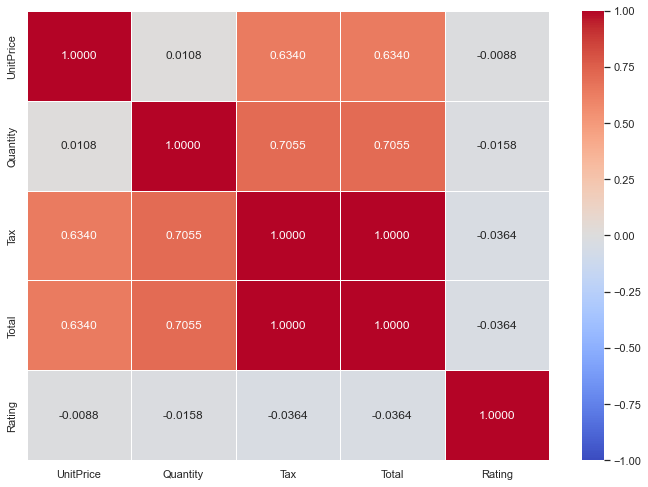

In [584]:
num_data = data.iloc[:,1:].select_dtypes(include = ["float64","int64"]) # InvoiceID is dropped as it is redundant for prediction
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(num_data.corr(),annot=True,cmap="coolwarm",linewidths=0.5,vmin=-1,vmax=1,fmt=".4f")

##### We see from the above heatmap that Tax and Total are perfectly correlated (correlation coefficient = 1). So in building a classfier we can drop one of Tax or Total with no loss of information.

### Checking for outliers

<AxesSubplot:>

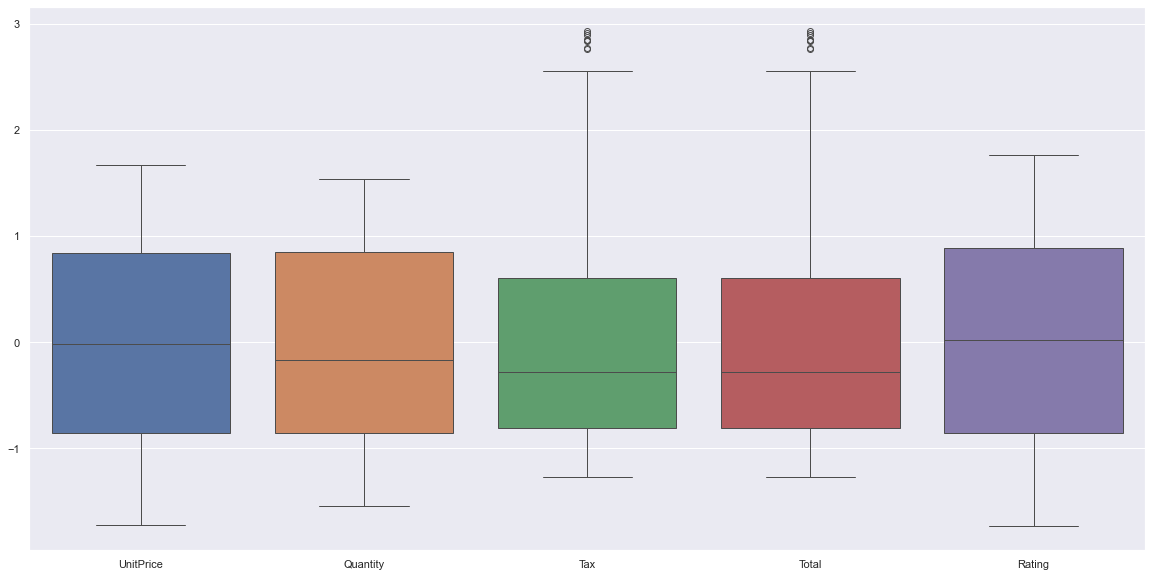

In [585]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
scaler = StandardScaler()
num_col = [col for col in data.select_dtypes(include=['int64','float64']).columns] 
scaler.set_output(transform='pandas')
scaler.fit(data[num_col])
# sns.boxplot(pd.DataFrame(box.fit_transform(data.iloc[:,1:].select_dtypes(include = ["int64","float64"]))))
sns.boxplot(scaler.transform(data[num_col]))

We see that Tax and Total have a few outliers from the above Boxplots. Also as these two are perfectly correlated, all outliers in both these features correspond to the same row in the dataframe

In [586]:
scaler.transform(data[num_col]).describe()

,UnitPrice,Quantity,Tax,Total,Rating
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.065814e-16,6.394885e-17,1.243450e-16,3.197442e-17,1.882938e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.721668e+00,-1.543480e+00,-1.270692e+00,-1.270692e+00,-1.730607e+00
25%,-8.608740e-01,-8.590099e-01,-8.078714e-01,-8.078714e-01,-8.573570e-01
50%,-1.669588e-02,-1.745399e-01,-2.812422e-01,-2.812422e-01,1.589315e-02
75%,8.406991e-01,8.521652e-01,6.037682e-01,6.037682e-01,8.891433e-01
max,1.672416e+00,1.536635e+00,2.928371e+00,2.928371e+00,1.762394e+00


### Encoding the non-numeric columns in the data

In [587]:
obj_columns = data.iloc[:,1:].select_dtypes(include=['object']).columns
obj_columns = list(obj_columns) # columns of data with type object
obj_columns = [obj for obj in obj_columns if obj != 'Gender']

In [588]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
enc = OneHotEncoder(sparse_output=False)
encoded_data = enc.fit_transform(data[obj_columns])
encoded_df = pd.DataFrame(
    encoded_data,columns= enc.get_feature_names_out(obj_columns)
)

data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

In [589]:
encoded_df.dtypes

Branch_A                              float64
Branch_B                              float64
Branch_C                              float64
CustomerType_Member                   float64
CustomerType_Normal                   float64
ProductType_Electronic accessories    float64
ProductType_Fashion accessories       float64
ProductType_Food and beverages        float64
ProductType_Health and beauty         float64
ProductType_Home and lifestyle        float64
ProductType_Sports and travel         float64
PaymentType_Cash                      float64
PaymentType_Credit card               float64
PaymentType_UPI                       float64
dtype: object

In [590]:
for col in encoded_df:
    data[col]=encoded_df[col]

In [591]:
data.shape

(1000, 25)

In [592]:
data.head()

,InvoiceID,Branch,CustomerType,Gender,ProductType,UnitPrice,Quantity,Tax,Total,PaymentType,...,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
0,750-67-8428,A,Member,0,Health and beauty,74.69,7,26.1415,548.9715,UPI,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,226-31-3081,C,Normal,0,Electronic accessories,15.28,5,3.8200,80.2200,Cash,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,631-41-3108,A,Normal,1,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,123-19-1176,A,Member,1,Health and beauty,58.22,8,23.2880,489.0480,UPI,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,373-73-7910,A,Normal,1,Sports and travel,86.31,7,30.2085,634.3785,UPI,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [593]:
data = data.drop(obj_columns,axis=1)


In [594]:
data.head()

,InvoiceID,Gender,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,...,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
0,750-67-8428,0,74.69,7,26.1415,548.9715,9.1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,226-31-3081,0,15.28,5,3.8200,80.2200,9.6,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,631-41-3108,1,46.33,7,16.2155,340.5255,7.4,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,123-19-1176,1,58.22,8,23.2880,489.0480,8.4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,373-73-7910,1,86.31,7,30.2085,634.3785,5.3,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [595]:
data.dtypes

InvoiceID                              object
Gender                                  int32
UnitPrice                             float64
Quantity                                int64
Tax                                   float64
Total                                 float64
Rating                                float64
Branch_A                              float64
Branch_B                              float64
Branch_C                              float64
CustomerType_Member                   float64
CustomerType_Normal                   float64
ProductType_Electronic accessories    float64
ProductType_Fashion accessories       float64
ProductType_Food and beverages        float64
ProductType_Health and beauty         float64
ProductType_Home and lifestyle        float64
ProductType_Sports and travel         float64
PaymentType_Cash                      float64
PaymentType_Credit card               float64
PaymentType_UPI                       float64
dtype: object

Dropping outliers

In [596]:
iqr = 1.5*(np.percentile(data['Total'],75) - np.percentile(data['Total'],25)) #interquartile range multiplied by 1.5
sum(data['Total'] > iqr + np.percentile(data['Total'],75)) 

9

In [597]:
data[data['Total'] > iqr + np.percentile(data['Total'],75)]

,InvoiceID,Gender,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,...,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
166,234-65-2137,1,95.58,10,47.790,1003.590,4.8,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
167,687-47-8271,1,98.98,10,49.490,1039.290,8.7,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
350,860-79-0874,0,99.30,10,49.650,1042.650,6.6,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
357,554-42-2417,0,95.44,10,47.720,1002.120,5.2,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
422,271-88-8734,0,97.21,10,48.605,1020.705,8.7,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
557,283-26-5248,0,98.52,10,49.260,1034.460,4.5,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
699,751-41-9720,1,97.50,10,48.750,1023.750,8.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
792,744-16-7898,0,97.37,10,48.685,1022.385,4.9,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
996,303-96-2227,0,97.38,10,48.690,1022.490,4.4,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [598]:
data = data[data['Total'] <= iqr + np.percentile(data['Total'],75)]

#### In the data, gender columns male has been encoded as 1 and female as 0

In [599]:
data.describe()

,Gender,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,CustomerType_Member,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,0.500505,55.292482,5.469223,15.076417,316.604752,6.979717,0.342079,0.332997,0.324924,0.502523,0.497477,0.171544,0.176589,0.174571,0.153380,0.157417,0.166498,0.345106,0.309788,0.345106
std,0.500252,26.311619,2.905031,11.319504,237.709589,1.716957,0.474645,0.471523,0.468583,0.500246,0.500246,0.377174,0.381513,0.379792,0.360536,0.364377,0.372716,0.475643,0.462640,0.475643
min,0.000000,10.080000,1.000000,0.508500,10.678500,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.665000,3.000000,5.817500,122.167500,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,54.840000,5.000000,12.036000,252.756000,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.485000,8.000000,22.127000,464.667000,8.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,99.960000,10.000000,45.325000,951.825000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Proportion of Male and Female in given data after removing outliers

In [600]:
data['Gender'].value_counts() # male = 1, female = 0

1    496
0    495
Name: Gender, dtype: int64

In [601]:
data[data['Gender'] == 1].describe() #male

,Gender,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,CustomerType_Member,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
count,496.0,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,1.0,55.832319,5.264113,14.594585,306.486278,6.979839,0.358871,0.342742,0.298387,0.483871,0.516129,0.173387,0.163306,0.169355,0.177419,0.159274,0.157258,0.332661,0.296371,0.370968
std,0.0,25.670467,2.933058,11.252843,236.309705,1.681989,0.480154,0.475105,0.458012,0.500244,0.500244,0.378964,0.370018,0.375444,0.382409,0.366301,0.364411,0.471642,0.457118,0.483552
min,1.0,10.080000,1.000000,0.508500,10.678500,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,33.767500,3.000000,5.600000,117.600000,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,56.075000,5.000000,11.349000,238.329000,6.900000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,76.400000,8.000000,21.614375,453.901875,8.425000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.0,99.960000,10.000000,45.250000,950.250000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [602]:
data[data['Gender'] == 0].describe() #female

,Gender,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,CustomerType_Member,CustomerType_Normal,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
count,495.0,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,0.0,54.751556,5.674747,15.559222,326.743667,6.979596,0.325253,0.323232,0.351515,0.521212,0.478788,0.169697,0.189899,0.179798,0.129293,0.155556,0.175758,0.357576,0.323232,0.319192
std,0.0,26.953902,2.864919,11.376802,238.912840,1.752999,0.468943,0.468184,0.477926,0.500055,0.500055,0.375746,0.392618,0.384408,0.335863,0.362800,0.380999,0.479771,0.468184,0.466635
min,0.0,10.160000,1.000000,0.604500,12.694500,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,30.390000,3.000000,6.257250,131.402250,5.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,52.790000,6.000000,12.854000,269.934000,7.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,77.940000,8.000000,22.846250,479.771250,8.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.0,99.730000,10.000000,45.325000,951.825000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### **Splitting the data into training and testing data for gender prediction**

In [603]:
from sklearn.model_selection import train_test_split
pred_cols = []
for col in data.columns:
    if col not in ['Gender','InvoiceID','Tax']: # Tax dropped as it has perfect correlation with Total
        pred_cols.append(col)
Xg = data[pred_cols] # features to predict from
yg = data['Gender'] # label to predict
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg,yg,test_size=0.20,random_state=42) # splits 20% for test and 80% for training

In [604]:
pred_cols

['UnitPrice',
 'Quantity',
 'Total',
 'Rating',
 'Branch_A',
 'Branch_B',
 'Branch_C',
 'CustomerType_Member',
 'CustomerType_Normal',
 'ProductType_Electronic accessories',
 'ProductType_Fashion accessories',
 'ProductType_Food and beverages',
 'ProductType_Health and beauty',
 'ProductType_Home and lifestyle',
 'ProductType_Sports and travel',
 'PaymentType_Cash',
 'PaymentType_Credit card',
 'PaymentType_UPI']

## **1. Building a classifier to predict Gender**

### **1.a. Using a Decision Tree Classifier**

In [605]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [728]:
parameters_dtc = {}
parameters_dtc['criterion'] = ['gini','entropy']
parameters_dtc['max_depth'] = [2,3,4,5,6,None]
parameters_dtc['max_features'] = ['log2','sqrt']
parameters_dtc['ccp_alpha'] = [0,0.005,0.010,0.015,0.020]
parameters_dtc['random_state'] = [42]

#### Hyperparametric Tuning

In [729]:
from sklearn.model_selection import GridSearchCV
dtc_gender = GridSearchCV(dtc,param_grid=parameters_dtc,cv=3,n_jobs=-1,verbose=3,scoring='accuracy')

#### Fitting the data

In [730]:
dtc_gender.fit(Xg_train,yg_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.005, 0.01, 0.015, 0.02],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, None],
                         'max_features': ['log2', 'sqrt'],
                         'random_state': [42]},
             scoring='accuracy', verbose=3)

#### Visualizing the Tree

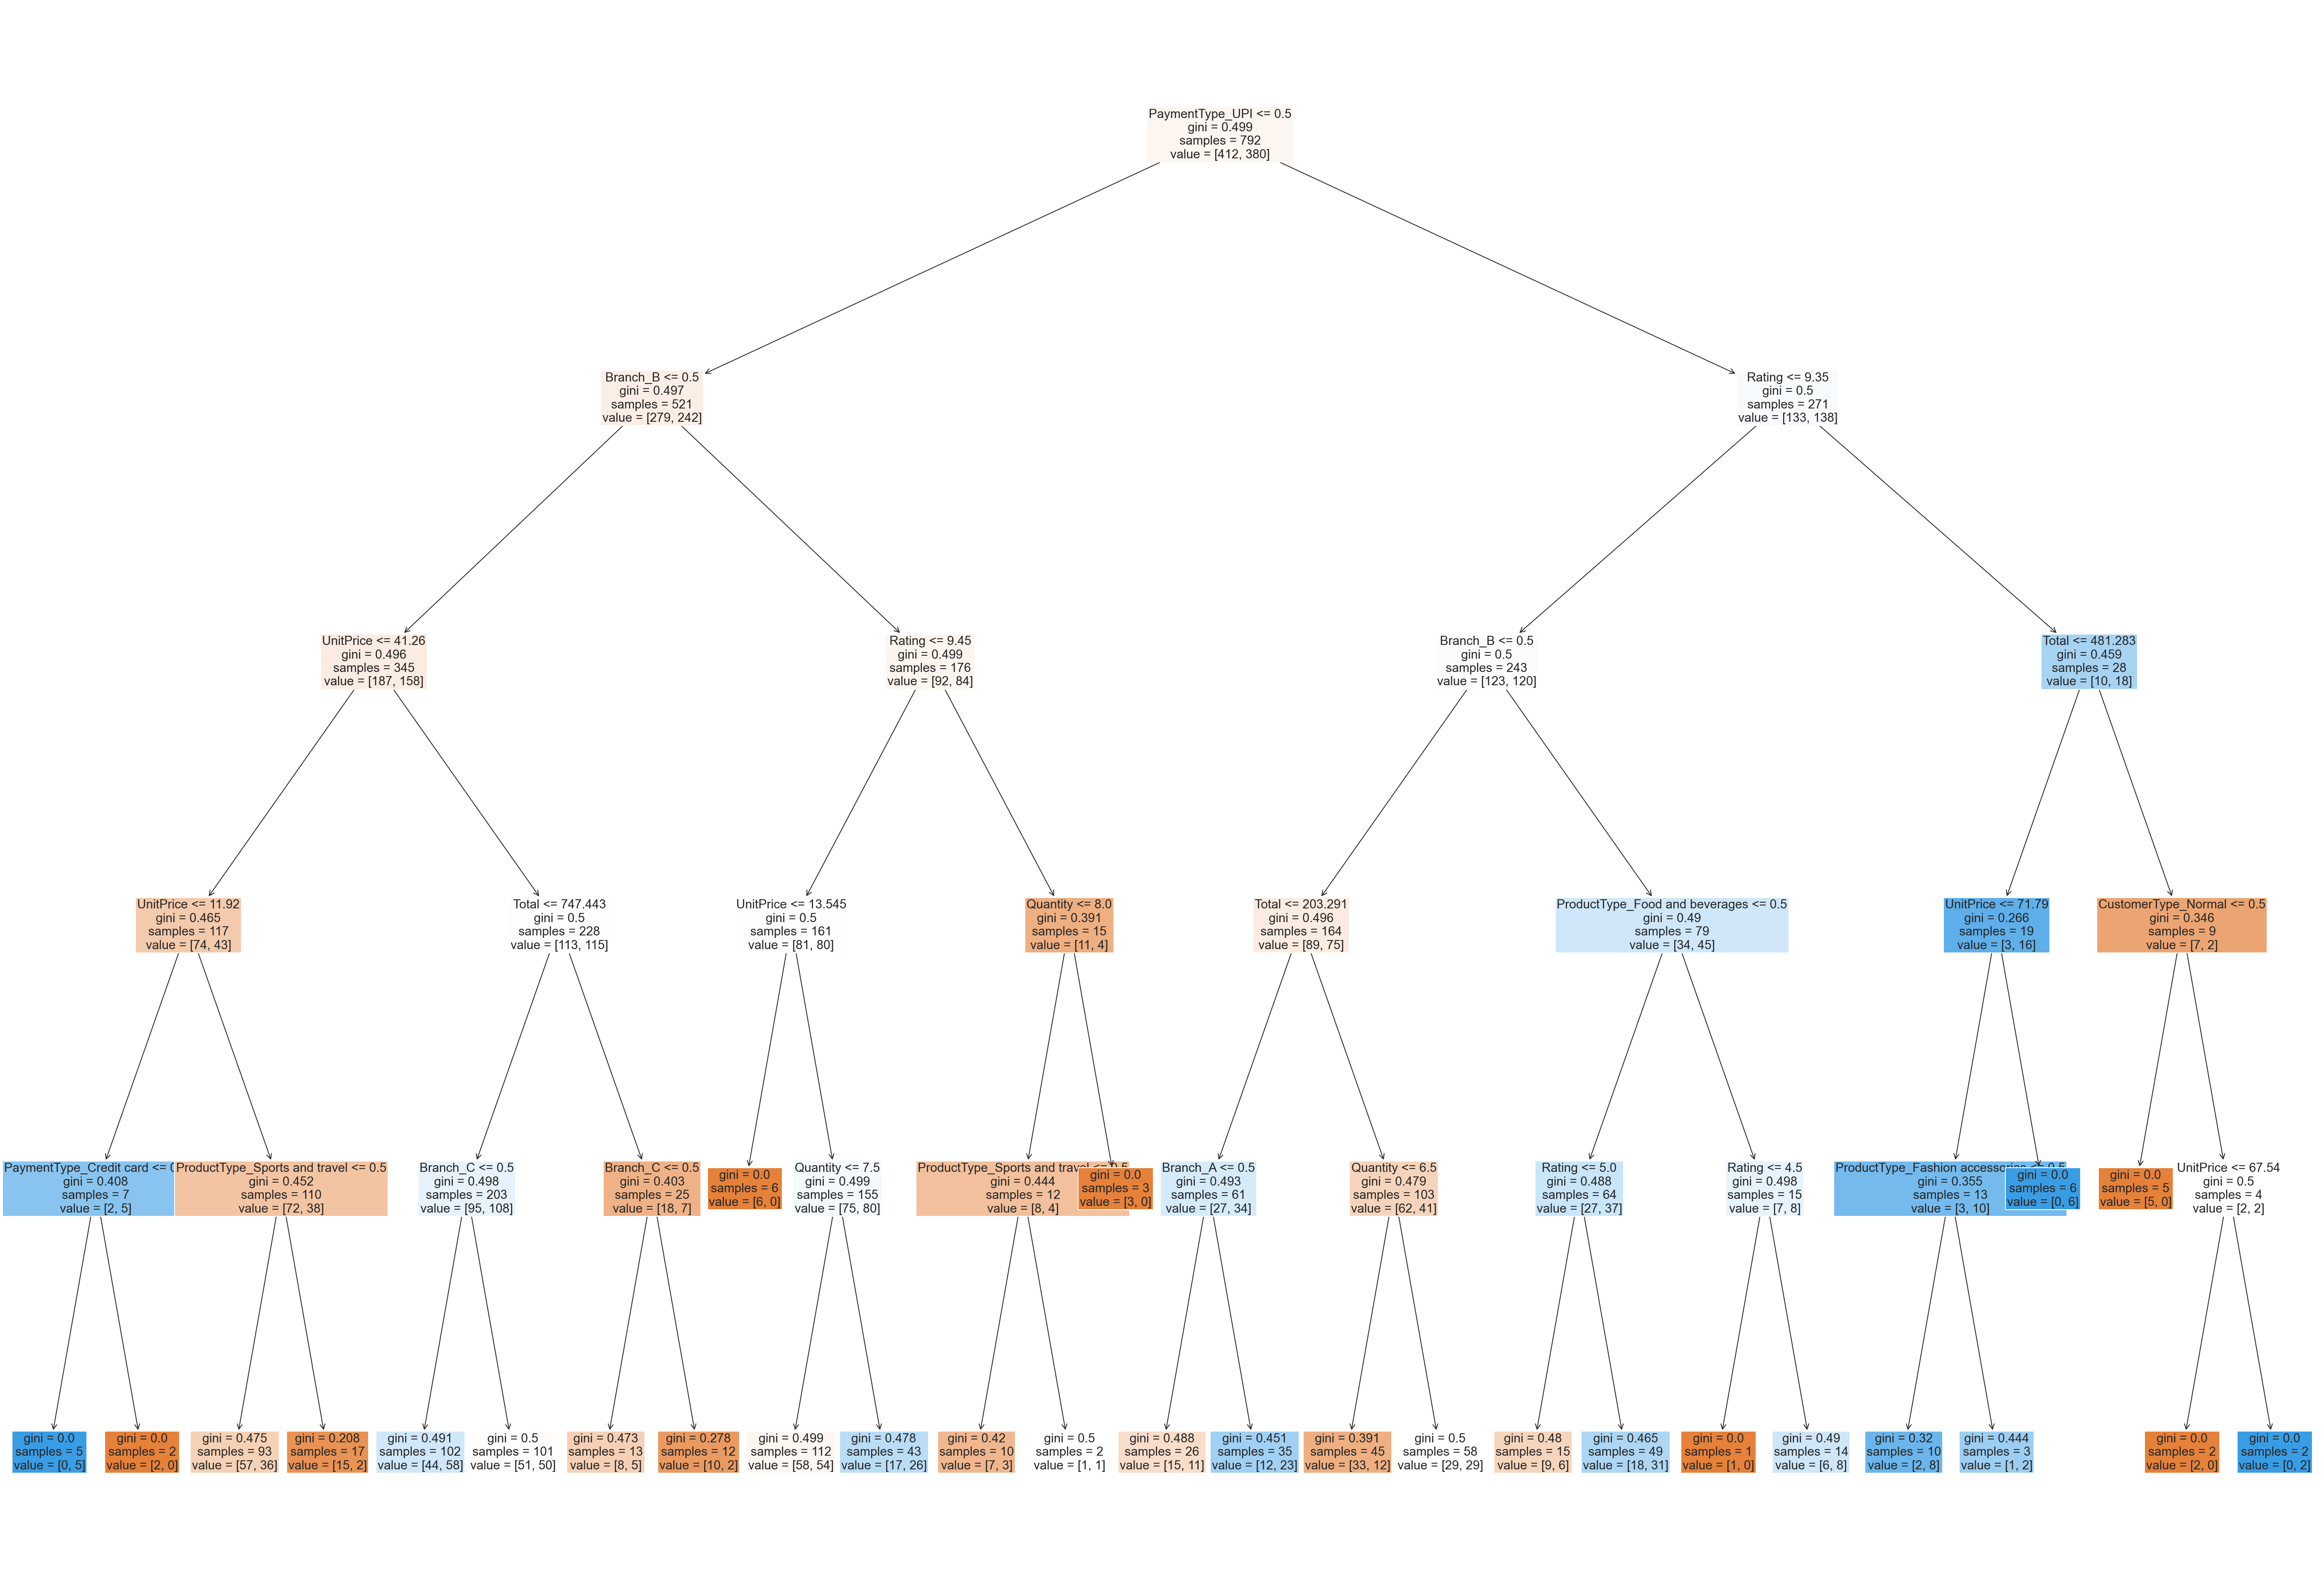

In [731]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(100,70))
_ = plot_tree(dtc_gender.best_estimator_,feature_names=list(Xg.columns),filled=True,fontsize=30)


#### The best parameters found and Accuracy on the training data

In [732]:
dtc_gender.best_params_ # best parameters found by hyperparametric tuning

{'ccp_alpha': 0,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'random_state': 42}

In [733]:
dtc_gender = dtc_gender.best_estimator_
dtc_gender.score(Xg_train,yg_train)

0.6073232323232324

In [734]:
dtc_gender.get_params()

{'ccp_alpha': 0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Classsification Report for training data

In [735]:
print(classification_report(yg_train,dtc_gender.predict(Xg_train),target_names=['Female','Male'],digits=3))

              precision    recall  f1-score   support

      Female      0.597     0.757     0.667       412
        Male      0.628     0.445     0.521       380

    accuracy                          0.607       792
   macro avg      0.612     0.601     0.594       792
weighted avg      0.612     0.607     0.597       792



confusion matrix for training data

In [736]:
confusion_matrix(y_true=yg_train,y_pred=dtc_gender.predict(Xg_train))

array([[312, 100],
       [211, 169]], dtype=int64)

Feature importance according to Decision Tree

In [615]:
dict(zip(dtc_gender.feature_names_in_,dtc_gender.feature_importances_))

{'UnitPrice': 0.2579079692599452,
 'Quantity': 0.10681239111281864,
 'Total': 0.23929237520479338,
 'Rating': 0.11180349191228568,
 'Branch_A': 0.04132304241799066,
 'Branch_B': 0.03619325822035739,
 'Branch_C': 0.028877139627507768,
 'CustomerType_Member': 0.0,
 'CustomerType_Normal': 0.028088710654395225,
 'ProductType_Electronic accessories': 0.0,
 'ProductType_Fashion accessories': 0.002074243248324603,
 'ProductType_Food and beverages': 0.0012326588449359844,
 'ProductType_Health and beauty': 0.0,
 'ProductType_Home and lifestyle': 0.0,
 'ProductType_Sports and travel': 0.056129936512445126,
 'PaymentType_Cash': 0.0,
 'PaymentType_Credit card': 0.07222811311130203,
 'PaymentType_UPI': 0.018036669872898228}

#### Accuracy on the Test Data

In [616]:
dtc_gender.score(Xg_test,yg_test)

0.5175879396984925

#### Confusion Matrix for test data

In [617]:
confusion_matrix(y_true=yg_test,y_pred=dtc_gender.predict(Xg_test))

array([[56, 27],
       [69, 47]], dtype=int64)

#### Accuracy, F score, Precision and Recall

In [618]:
lab = ['Accuracy','F Score','Precision','Recall']
score = [dtc_gender.score(Xg_test,yg_test),f1_score(yg_test,dtc_gender.predict(Xg_test)),
         precision_score(yg_test,dtc_gender.predict(Xg_test)),recall_score(yg_test,dtc_gender.predict(Xg_test))]
dtctest = pd.DataFrame((zip(lab,score)),columns=["Metric","score"])
dtctest

,Metric,score
0,Accuracy,0.517588
1,F Score,0.494737
2,Precision,0.635135
3,Recall,0.405172


### **1.b. Using a Random Forest Classifier**

In [619]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [620]:
parameters_rfc = {}
parameters_rfc['n_estimators'] = [50,75,100,125,150,175,200,250,300]
parameters_rfc['criterion'] = ['gini']
parameters_rfc['max_features'] = ["log2","sqrt"]
parameters_rfc['max_depth'] = [2,3]
parameters_rfc['random_state'] = [0]

#### Fitting the data with Hyperparametric Tuning

In [621]:
rfc_gender = GridSearchCV(rfc,param_grid=parameters_rfc,n_jobs=-1,cv=3,scoring='accuracy',verbose=3)
rfc_gender.fit(Xg_train,yg_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [2, 3],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200, 250,
                                          300],
                         'random_state': [0]},
             scoring='accuracy', verbose=3)

#### Best parameters and score on the training data 

In [622]:
rfc_gender.best_score_ # best score in validation

0.5277777777777778

In [623]:
rfc_gender.best_params_ # best parameters found by hyperparametric tuning

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 200,
 'random_state': 0}

In [624]:
rfc_gender = rfc_gender.best_estimator_

In [625]:
rfc_gender.get_params() # parameters

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [626]:
rfc_gender.score(Xg_train,yg_train) # accuracy on training data

0.6363636363636364

Classification Report for training data

In [627]:
print(classification_report(yg_train,rfc_gender.predict(Xg_train),target_names=['Female','Male'],digits=3))

              precision    recall  f1-score   support

      Female      0.607     0.852     0.709       412
        Male      0.715     0.403     0.515       380

    accuracy                          0.636       792
   macro avg      0.661     0.627     0.612       792
weighted avg      0.659     0.636     0.616       792



Confusion Matrix for training data

In [628]:
confusion_matrix(yg_train,rfc_gender.predict(Xg_train))

array([[351,  61],
       [227, 153]], dtype=int64)

#### Accuracy on the test data

In [629]:
rfc_gender.score(Xg_test,yg_test)

0.5276381909547738

F score, Accuracy, Precision and Recall for test data

In [630]:
lab = ['Accuracy','F Score','Precision','Recall']
score = [rfc_gender.score(Xg_test,yg_test),f1_score(yg_test,rfc_gender.predict(Xg_test)),
         precision_score(yg_test,rfc_gender.predict(Xg_test)),recall_score(yg_test,rfc_gender.predict(Xg_test))]
rfctest = pd.DataFrame((zip(lab,score)),columns=["Metric","score"])
rfctest

,Metric,score
0,Accuracy,0.527638
1,F Score,0.453488
2,Precision,0.696429
3,Recall,0.336207


Confusion matrix for test data

In [631]:
confusion_matrix(yg_test,rfc_gender.predict(Xg_test))

array([[66, 17],
       [77, 39]], dtype=int64)

### Comparing the results

Decision Tree

In [632]:
print("Decision Tree")
print(classification_report(yg_test,dtc_gender.predict(Xg_test),target_names=['Female','Male'],digits=3))

Decision Tree
              precision    recall  f1-score   support

      Female      0.448     0.675     0.538        83
        Male      0.635     0.405     0.495       116

    accuracy                          0.518       199
   macro avg      0.542     0.540     0.517       199
weighted avg      0.557     0.518     0.513       199



Random Forest

In [633]:
print("Random Forest")
print(classification_report(yg_test,rfc_gender.predict(Xg_test),target_names=['Female','Male'],digits=3))

Random Forest
              precision    recall  f1-score   support

      Female      0.462     0.795     0.584        83
        Male      0.696     0.336     0.453       116

    accuracy                          0.528       199
   macro avg      0.579     0.566     0.519       199
weighted avg      0.598     0.528     0.508       199



## **2. Building a model to predict Rating**

#### Distribution of Rating

<AxesSubplot:ylabel='Density'>

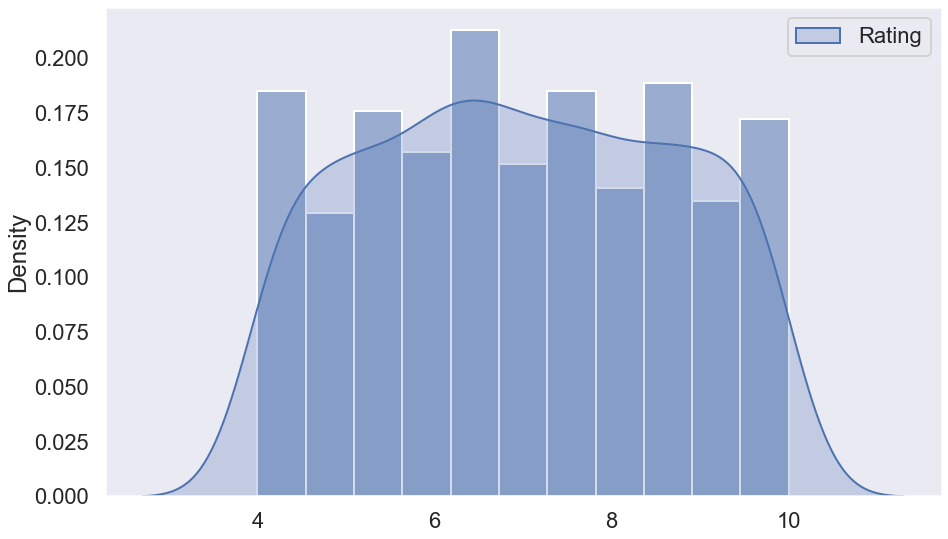

In [634]:
sns.set_theme(rc={'figure.figsize':(15,9)},style='dark',context='poster')
sns.histplot(data[['Rating']],stat='density')
sns.kdeplot(data[['Rating']],fill=True)

In [635]:
data[['Rating']].describe()

,Rating
count,991.000000
mean,6.979717
std,1.716957
min,4.000000
25%,5.500000
50%,7.000000
75%,8.500000
max,10.000000


Setting up the data for predicting Ratings

In [636]:
data = pd.read_csv("supermarket-sales-data.csv")
obj_columns = data.iloc[:,1:].select_dtypes(include=['object']).columns
obj_columns = list(obj_columns) # columns of data with type object

encoded_data = enc.fit_transform(data[obj_columns])
encoded_df = pd.DataFrame(
    encoded_data,columns= enc.get_feature_names_out(obj_columns)
)

data = data.drop(obj_columns,axis=1)
data = pd.concat([data,encoded_df],axis=1)

Removing outliers

In [637]:
data = data[data['Total'] <= iqr + np.percentile(data['Total'],75)]

In [638]:
data.shape

(991, 22)

In [639]:
data.head()

,InvoiceID,UnitPrice,Quantity,Tax,Total,Rating,Branch_A,Branch_B,Branch_C,CustomerType_Member,...,Gender_Male,ProductType_Electronic accessories,ProductType_Fashion accessories,ProductType_Food and beverages,ProductType_Health and beauty,ProductType_Home and lifestyle,ProductType_Sports and travel,PaymentType_Cash,PaymentType_Credit card,PaymentType_UPI
0,750-67-8428,74.69,7,26.1415,548.9715,9.1,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,226-31-3081,15.28,5,3.8200,80.2200,9.6,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,631-41-3108,46.33,7,16.2155,340.5255,7.4,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,123-19-1176,58.22,8,23.2880,489.0480,8.4,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,373-73-7910,86.31,7,30.2085,634.3785,5.3,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [640]:
pred_cols = []
for col in data.columns:
    if col not in ['Rating','InvoiceID','Tax']: # Tax dropped as it has perfect correlation with Total
        pred_cols.append(col)
Xr = data[pred_cols] # features to predict from
yr = data['Rating'] # label to predict

### Splitting data for training and testing

In [641]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr,yr,test_size=0.20,random_state=42) # splits 20% for test and 80% for training

In [642]:
pred_cols

['UnitPrice',
 'Quantity',
 'Total',
 'Branch_A',
 'Branch_B',
 'Branch_C',
 'CustomerType_Member',
 'CustomerType_Normal',
 'Gender_Female',
 'Gender_Male',
 'ProductType_Electronic accessories',
 'ProductType_Fashion accessories',
 'ProductType_Food and beverages',
 'ProductType_Health and beauty',
 'ProductType_Home and lifestyle',
 'ProductType_Sports and travel',
 'PaymentType_Cash',
 'PaymentType_Credit card',
 'PaymentType_UPI']

### **2.1. Using Linear Regression**

In [643]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [644]:
lm_rmse = {} #dictionary to store RMSE of Linear regression on Test Data
lm_r2 = {} #dictionary to store R^2 score of Linear regression on Test Data

#### 2.1.1 Fitting a linear model (degree 1) with all the given features without regularisation

In [645]:
lm.fit(Xr_train,yr_train)

LinearRegression()

##### intercept and coefficients

In [646]:
lm.intercept_,lm.coef_

(6.572073226822145,
 array([ 0.00741876,  0.06960201, -0.00119465,  0.05584096, -0.08694471,
         0.03110375, -0.00483698,  0.00483698,  0.02223365, -0.02223365,
        -0.01572582, -0.06042518,  0.14047907,  0.13267905, -0.09571592,
        -0.1012912 ,  0.08020582, -0.00499905, -0.07520677]))

RMSE and $R^2$ as a metric for score

In [647]:
from sklearn.metrics import mean_squared_error,r2_score


 RMSE and $R^2$ on the Training data

In [648]:
mean_squared_error(yr_train,lm.predict(Xr_train),squared=False) # RMSE

1.721654584400413

In [649]:
r2_score(yr_train,lm.predict(Xr_train))

0.00969312368423858

 RMSE and $R^2$ on the Test Data

In [650]:
mean_squared_error(yr_test,lm.predict(Xr_test),squared=False)

1.6704123553991768

In [651]:
r2_score(yr_test,lm.predict(Xr_test))

-0.013935114421145256

In [652]:
lm_rmse['Linear Regression degree 1'] = mean_squared_error(yr_test,lm.predict(Xr_test),squared=False)
lm_r2['Linear Regression degree 1'] = r2_score(yr_test,lm.predict(Xr_test))

#### 2.1.2 Fitting a linear model (degree 1 ) with Lasso


In [653]:
from sklearn.linear_model import Lasso
lm2 = Lasso(alpha=0.5)
lm2.fit(Xr_train,yr_train)

Lasso(alpha=0.5)

In [654]:
lm2.intercept_,lm2.coef_

(6.986613677249039,
 array([ 0.00063768,  0.        , -0.00010718,  0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        , -0.        ]))

Score on training data

In [655]:
mean_squared_error(yr_train,lm2.predict(Xr_train),squared=False)

1.7297308525651394

In [656]:
r2_score(yr_train,lm2.predict(Xr_train))

0.00038028798416822607

Score on test data

In [657]:
mean_squared_error(yr_test,lm2.predict(Xr_test),squared=False)

1.6581881561383902

In [658]:
r2_score(yr_test,lm2.predict(Xr_test))

0.0008506871149518425

In [659]:
lm_rmse['Lasso degree 1'] = mean_squared_error(yr_test,lm2.predict(Xr_test),squared=False)
lm_r2['Lasso degree 1'] = r2_score(yr_test,lm2.predict(Xr_test))

#### 2.1.3 Fitting a linear model (degree 1 ) with Ridge

In [660]:
from sklearn.linear_model import Ridge
lm3 = Ridge(alpha=10)
lm3.fit(Xr_train,yr_train)

Ridge(alpha=10)

In [661]:
lm3.intercept_,lm3.coef_

(6.574643789054377,
 array([ 0.00738139,  0.06911676, -0.00118766,  0.05352333, -0.08409065,
         0.03056732, -0.00464177,  0.00464177,  0.0216273 , -0.0216273 ,
        -0.01438766, -0.05657966,  0.13168614,  0.12227757, -0.08841738,
        -0.09457901,  0.07747736, -0.00466261, -0.07281475]))

Score on training data

In [662]:
mean_squared_error(yr_train,lm3.predict(Xr_train),squared=False)

1.7216720981491733

In [663]:
r2_score(yr_train,lm3.predict(Xr_train))

0.009672975538145168

Score on test data

In [664]:
mean_squared_error(yr_test,lm3.predict(Xr_test),squared=False)

1.6694466480658698

In [665]:
r2_score(yr_test,lm3.predict(Xr_test))

-0.01276309060018388

In [666]:
lm_rmse['Ridge degree 1'] = mean_squared_error(yr_test,lm3.predict(Xr_test),squared=False)
lm_r2['Ridge degree 1'] = r2_score(yr_test,lm3.predict(Xr_test))

#### 2.1.4 Fitting a linear model (degree 1) with Elastic Net

In [667]:
from sklearn.linear_model import ElasticNet
lm4 = ElasticNet(max_iter=10**4,alpha=0.1,l1_ratio=0.5)
lm4.fit(Xr_train,yr_train)

ElasticNet(alpha=0.1, max_iter=10000)

In [668]:
lm4.intercept_,lm4.coef_

(6.762918401696269,
 array([ 0.00453245,  0.03476191, -0.00068414,  0.        , -0.        ,
         0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        , -0.        ]))

Score on training data

In [669]:
mean_squared_error(yr_train,lm4.predict(Xr_train),squared=False)

1.7278555491458418

In [670]:
r2_score(yr_train,lm4.predict(Xr_train))

0.002546606615912439

Score on test data

In [671]:
mean_squared_error(yr_test,lm4.predict(Xr_test),squared=False)

1.6584597177478246

In [672]:
r2_score(yr_test,lm4.predict(Xr_test))

0.0005233987883711544

In [673]:
lm_rmse['ElasticNet degree 1'] = mean_squared_error(yr_test,lm4.predict(Xr_test),squared=False)
lm_r2['ElasticNet degree 1'] = r2_score(yr_test,lm4.predict(Xr_test))

#### 2.1.5 Fitting a quadratic polynomial with lasso regularisation

In [674]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

poly.fit(X_poly_train)
lm5 = Lasso(alpha=1,max_iter=10**9)
lm5.fit(X_poly_train, yr_train)

Lasso(alpha=1, max_iter=1000000000)

In [675]:
# lm5.intercept_,lm5.coef_

score on training data

In [676]:
mean_squared_error(yr_train,lm5.predict(X_poly_train),squared=False)

1.7212698198894687

In [677]:
r2_score(yr_train,lm5.predict(X_poly_train))

0.010135712303984024

score on test data

In [678]:
mean_squared_error(yr_test,lm5.predict(X_poly_test),squared=False)

1.6648186662152211

In [679]:
r2_score(yr_train,lm5.predict(X_poly_train))

0.010135712303984024

In [680]:
lm_rmse['Lasso degree 2'] = mean_squared_error(yr_test,lm5.predict(X_poly_test),squared=False)
lm_r2['Lasso degree 2'] = r2_score(yr_train,lm5.predict(X_poly_train))

#### 2.1.6 Fitting a quadratic polynomial with Ridge

In [681]:
poly = PolynomialFeatures(degree=2,interaction_only=False)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

# poly.fit(X_poly_train)
lm6 = Ridge(alpha=1,max_iter=10**9)
lm6.fit(X_poly_train, yr_train)

Ridge(alpha=1, max_iter=1000000000)

In [682]:
# lm6.intercept_,lm6.coef_

Score on training data

In [683]:
mean_squared_error(yr_train,lm6.predict(X_poly_train),squared=False)

1.6481299708448456

In [684]:
r2_score(yr_train,lm6.predict(X_poly_train))

0.09247068620106336

Score on test data

In [685]:
mean_squared_error(yr_test,lm6.predict(X_poly_test),squared=False)

1.6977632868476666

In [686]:
r2_score(yr_test,lm6.predict(X_poly_test))

-0.047410811423385546

In [687]:
lm_rmse['Ridge degree 2'] = mean_squared_error(yr_test,lm6.predict(X_poly_test),squared=False)
lm_r2['Ridge degree 2'] = r2_score(yr_test,lm6.predict(X_poly_test))

#### 2.1.7 Fitting a Quadratic Poynomial with Elastic Net

In [688]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

poly.fit(X_poly_train)
lm7 = ElasticNet(max_iter=10**9,alpha=5,l1_ratio=0.5)
lm7.fit(X_poly_train, yr_train)

ElasticNet(alpha=5, max_iter=1000000000)

In [689]:
# lm7.intercept_,lm7.coef_

Score on training data

In [690]:
mean_squared_error(yr_train,lm7.predict(X_poly_train),squared=False)

1.7225264015767119

In [691]:
r2_score(yr_train,lm7.predict(X_poly_train))

0.008689919964264159

Score on test data

In [692]:
mean_squared_error(yr_test,lm7.predict(X_poly_test),squared=False)

1.6659116880640754

In [693]:
r2_score(yr_test,lm7.predict(X_poly_test))

-0.008478692875727445

In [694]:
lm_rmse['ElasticNet degree 2'] = mean_squared_error(yr_test,lm7.predict(X_poly_test),squared=False)
lm_r2['ElasticNet degree 2'] = r2_score(yr_test,lm7.predict(X_poly_test))

#### 2.1.8 Fitting a quadratic polynomial without regularisation

In [695]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(Xr_train)
X_poly_test = poly.fit_transform(Xr_test)

lm8 = LinearRegression()
lm8.fit(X_poly_train, yr_train)

LinearRegression()

In [696]:
lm8.intercept_,lm.coef_

(411494.1618748809,
 array([ 0.00741876,  0.06960201, -0.00119465,  0.05584096, -0.08694471,
         0.03110375, -0.00483698,  0.00483698,  0.02223365, -0.02223365,
        -0.01572582, -0.06042518,  0.14047907,  0.13267905, -0.09571592,
        -0.1012912 ,  0.08020582, -0.00499905, -0.07520677]))

Score on training data

In [697]:
mean_squared_error(yr_train,lm8.predict(X_poly_train),squared=False)

1.6480844945509432

In [698]:
r2_score(yr_train,lm8.predict(X_poly_train))

0.092520767810087

Score on test data

In [699]:
mean_squared_error(yr_test,lm8.predict(X_poly_test),squared=False)

1.7011870315767783

In [700]:
r2_score(yr_test,lm8.predict(X_poly_test))

-0.05163953181273784

In [701]:
lm_rmse['Linear regression degree 2'] = mean_squared_error(yr_test,lm8.predict(X_poly_test),squared=False)
lm_r2['Linear regression degree 2'] = r2_score(yr_test,lm8.predict(X_poly_test))

### 2.2 Using Decision Tree Regressor

In [765]:
from sklearn.tree import DecisionTreeRegressor

parameters_dtr = {}
parameters_dtr['max_depth'] = [3,5,6,8,9,11,13,None]
parameters_dtr['max_features'] = [None,'sqrt','log2']
parameters_dtr['splitter'] = ['best','random']
parameters_dtr['random_state'] = [0]

In [766]:
dtr = GridSearchCV(DecisionTreeRegressor(),param_grid=parameters_dtr,n_jobs=-1,cv=3,verbose =3,scoring='neg_root_mean_squared_error')
dtr.fit(Xr_train,yr_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8, 9, 11, 13, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [767]:
dtr.best_params_ #best parameters found by hyperparametric tuning

{'max_depth': 3, 'max_features': 'sqrt', 'random_state': 0, 'splitter': 'best'}

In [768]:
-dtr.best_score_ # best score on cross validation

1.766311950650239

In [769]:
dtr = dtr.best_estimator_

In [770]:
dtr.get_depth()

3

In [771]:
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [772]:
mean_squared_error(yr_train,dtr.predict(Xr_train),squared=False)

1.7170498896901056

In [773]:
r2_score(yr_train,dtr.predict(Xr_train))

0.014983340157776026

Visualizing the Regression Tree

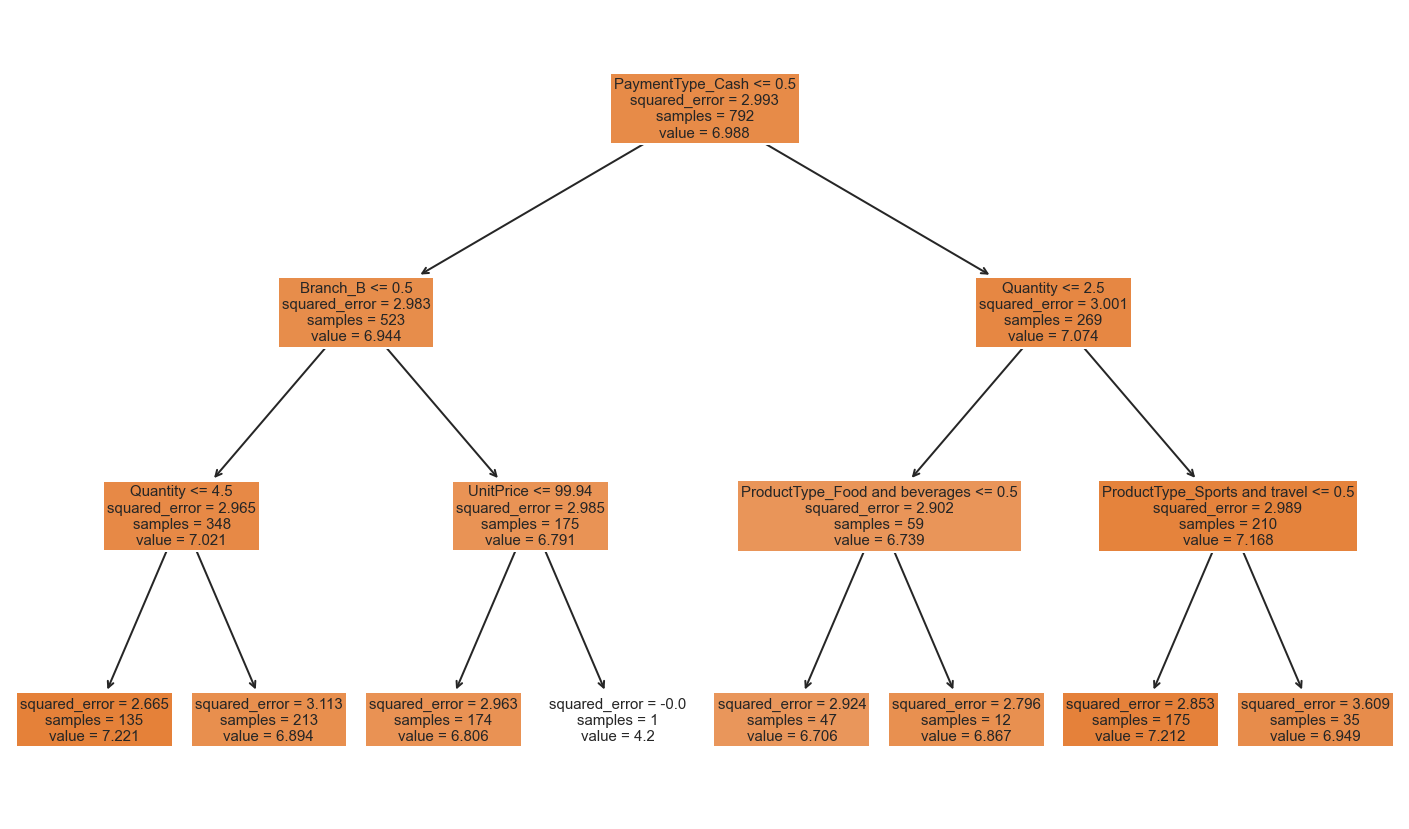

In [774]:
plt.figure(figsize=(25,15))
# _ = plot_tree(dtr.best_estimator_,feature_names=list(Xr.columns),filled=True)
_ = plot_tree(dtr,feature_names=list(Xr.columns),filled=True,fontsize = 15)

RMSE on test data

In [775]:
mean_squared_error(yr_test,dtr.predict(Xr_test),squared=False)

1.6577577515942812

In [776]:
r2_score(yr_test,dtr.predict(Xr_test))

0.0013693044888071215

Feature importance as per decision tree

In [777]:
imp = dict(zip(dtr.feature_names_in_,dtr.feature_importances_))
imp

{'UnitPrice': 0.19007266405026452,
 'Quantity': 0.4877151129905513,
 'Total': 0.0,
 'Branch_A': 0.0,
 'Branch_B': 0.17404105913119228,
 'Branch_C': 0.0,
 'CustomerType_Member': 0.0,
 'CustomerType_Normal': 0.0,
 'Gender_Female': 0.0,
 'Gender_Male': 0.0,
 'ProductType_Electronic accessories': 0.0,
 'ProductType_Fashion accessories': 0.0,
 'ProductType_Food and beverages': 0.006914323142346724,
 'ProductType_Health and beauty': 0.0,
 'ProductType_Home and lifestyle': 0.0,
 'ProductType_Sports and travel': 0.05698446548035135,
 'PaymentType_Cash': 0.08427237520529392,
 'PaymentType_Credit card': 0.0,
 'PaymentType_UPI': 0.0}

Performance of Linear regression in predicting ratings 

In [778]:
print('Performance of various Linear Regression on Test data')
pd.DataFrame(zip(lm_rmse.keys(),lm_rmse.values(),lm_r2.values()),columns=['Type of Linear Regression','RMSE','R2'])

Performance of various Linear Regression on Test data


,Type of Linear Regression,RMSE,R2
0,Linear Regression degree 1,1.670412,-0.013935
1,Lasso degree 1,1.658188,0.000851
2,Ridge degree 1,1.669447,-0.012763
3,ElasticNet degree 1,1.658460,0.000523
4,Lasso degree 2,1.664819,0.010136
5,Ridge degree 2,1.697763,-0.047411
6,ElasticNet degree 2,1.665912,-0.008479
7,Linear regression degree 2,1.701187,-0.051640


Performance of decision tree in predicting ratings 

In [779]:
mean_squared_error(yr_test,dtr.predict(Xr_test),squared=False)

1.6577577515942812

In [780]:
r2_score(yr_test,dtr.predict(Xr_test))

0.0013693044888071215